<a href="https://colab.research.google.com/github/Vasugi2003/Big-Data-Analytics/blob/main/WindowFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=d4260489aaeb03dbf9448bee3a57e14cf7ffd01d3c18a61ad456ea8430ea48c4
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
# Step 2: Create a Spark session
spark = SparkSession.builder\
.appName("PySpark_WindowFunction_Example").getOrCreate()

PySpark Window functions are used to calculate results such as the rank, row number e.t.c over a range of input rows.

In this article, I’ve explained the concept of window functions, syntax, and finally how to use them with PySpark SQL and PySpark DataFrame API.

These come in handy when we need to make aggregate operations in a specific window frame on DataFrame columns.


When possible try to leverage standard library as they are little bit more compile-time safety, handles null and perform better when compared to UDF’s. If your application is critical on performance try to avoid using custom UDF at all costs as these are not guarantee on performance.

### 1. Window Functions

## * PySpark Window functions operate on a group of rows (like frame, partition) and return a single value for every input row.

* PySpark SQL supports three kinds of window functions:
  1. ranking functions
  2. analytic functions
  3. aggregate functions

*  The below table defines Ranking and Analytic functions and for aggregate functions, we can use any existing aggregate functions as a window function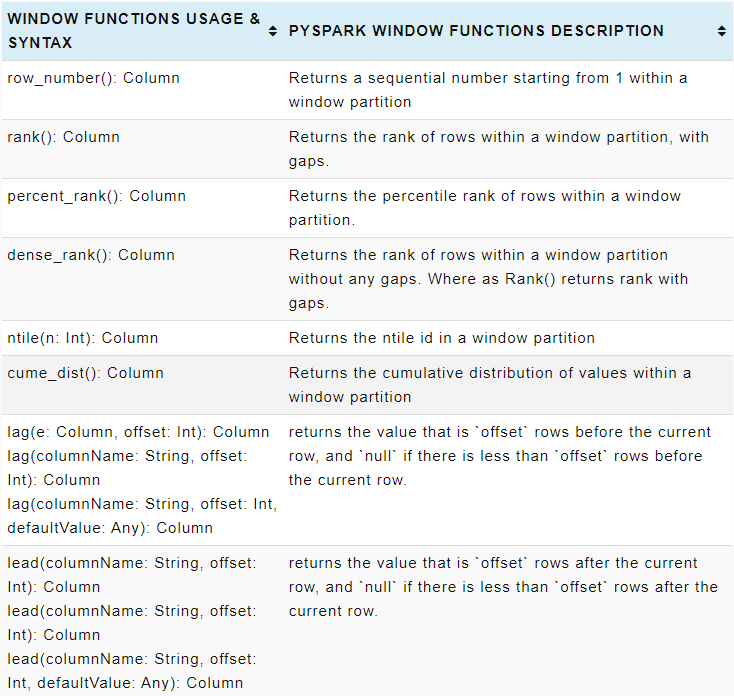



To perform an operation on a group first, we
need to partition the data using Window.partitionBy() , and for row number and rank function we need to additionally order by on partition data using orderBy clause.

In [ ]:
simpleData = (("James", "Sales", 3000), \
    ("Michael", "Sales", 4600),  \
    ("Robert", "Sales", 4100),   \
    ("Maria", "Finance", 3000),  \
    ("James", "Sales", 3000),    \
    ("Scott", "Finance", 3300),  \
    ("Jen", "Finance", 3900),    \
    ("Jeff", "Marketing", 3000), \
    ("Kumar", "Marketing", 2000),\
    ("Saif", "Sales", 4100) \
  )

In [ ]:
columns= ["employee_name", "department", "salary"]
df = spark.createDataFrame\
          (data = simpleData, schema = columns)
df.printSchema()
df.show(truncate=False)

root
 |-- employee_name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: long (nullable = true)

+-------------+----------+------+
|employee_name|department|salary|
+-------------+----------+------+
|James        |Sales     |3000  |
|Michael      |Sales     |4600  |
|Robert       |Sales     |4100  |
|Maria        |Finance   |3000  |
|James        |Sales     |3000  |
|Scott        |Finance   |3300  |
|Jen          |Finance   |3900  |
|Jeff         |Marketing |3000  |
|Kumar        |Marketing |2000  |
|Saif         |Sales     |4100  |
+-------------+----------+------+



# 2. PySpark Window Ranking functions
* 2.1 row_number Window Function

  row_number() window function is used to give the sequential row number starting from 1 to the result of each window partition.

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec  = Window.partitionBy("department")\
                    .orderBy("salary")
df.withColumn("row_number",row_number().over(windowSpec)) \
    .show(truncate=False)


+-------------+----------+------+----------+
|employee_name|department|salary|row_number|
+-------------+----------+------+----------+
|Maria        |Finance   |3000  |1         |
|Scott        |Finance   |3300  |2         |
|Jen          |Finance   |3900  |3         |
|Kumar        |Marketing |2000  |1         |
|Jeff         |Marketing |3000  |2         |
|James        |Sales     |3000  |1         |
|James        |Sales     |3000  |2         |
|Robert       |Sales     |4100  |3         |
|Saif         |Sales     |4100  |4         |
|Michael      |Sales     |4600  |5         |
+-------------+----------+------+----------+



* 2.2 rank Window Function

  rank() window function is used to provide a rank to the result within a window partition. This function leaves gaps in rank when there are ties.

In [ ]:
from pyspark.sql.functions import rank
df.withColumn("rank",rank().over(windowSpec)) \
    .show()

+-------------+----------+------+----+
|employee_name|department|salary|rank|
+-------------+----------+------+----+
|        Maria|   Finance|  3000|   1|
|        Scott|   Finance|  3300|   2|
|          Jen|   Finance|  3900|   3|
|        Kumar| Marketing|  2000|   1|
|         Jeff| Marketing|  3000|   2|
|        James|     Sales|  3000|   1|
|        James|     Sales|  3000|   1|
|       Robert|     Sales|  4100|   3|
|         Saif|     Sales|  4100|   3|
|      Michael|     Sales|  4600|   5|
+-------------+----------+------+----+



* 2.3 dense_rank Window Function

  dense_rank() window function is used to get the result with rank of rows within a window partition without any gaps.
  
  This is similar to rank() function difference being rank function leaves gaps in rank when there are ties



In [ ]:
"""dens_rank"""
from pyspark.sql.functions import dense_rank
df.withColumn("dense_rank",dense_rank().over(windowSpec)) \
    .show()

+-------------+----------+------+----------+
|employee_name|department|salary|dense_rank|
+-------------+----------+------+----------+
|        Maria|   Finance|  3000|         1|
|        Scott|   Finance|  3300|         2|
|          Jen|   Finance|  3900|         3|
|        Kumar| Marketing|  2000|         1|
|         Jeff| Marketing|  3000|         2|
|        James|     Sales|  3000|         1|
|        James|     Sales|  3000|         1|
|       Robert|     Sales|  4100|         2|
|         Saif|     Sales|  4100|         2|
|      Michael|     Sales|  4600|         3|
+-------------+----------+------+----------+



* 2.4 percent_rank Window Function



“Percentile” is in everyday use, but there is no universal definition for it. The most common definition of a percentile is a number where a certain percentage of scores fall below that number. You might know that you scored 67 out of 90 on a test. But that figure has no real meaning unless you know what percentile you fall into. If you know that your score is in the 90th percentile, that means you scored better than 90% of people who took the test




How to calculate percentile
Before you can calculate percentile rank, you need to know the percentile of the item you're ranking. You can find the percentile of a specific score using this formula:

Percentile = (number of values below score) ÷ (total number of scores) x 100


Percentile rank formula
You can calculate the percentile rank using this formula:

Percentile rank = p / 100 x (n + 1)

In the equation:

p represents the percentile
n represents the total number of items in the data set.

In [ ]:
""" percent_rank """
from pyspark.sql.functions import percent_rank
df.withColumn("percent_rank",percent_rank().over(windowSpec)) \
    .show()

+-------------+----------+------+------------+
|employee_name|department|salary|percent_rank|
+-------------+----------+------+------------+
|        Maria|   Finance|  3000|         0.0|
|        Scott|   Finance|  3300|         0.5|
|          Jen|   Finance|  3900|         1.0|
|        Kumar| Marketing|  2000|         0.0|
|         Jeff| Marketing|  3000|         1.0|
|        James|     Sales|  3000|         0.0|
|        James|     Sales|  3000|         0.0|
|       Robert|     Sales|  4100|         0.5|
|         Saif|     Sales|  4100|         0.5|
|      Michael|     Sales|  4600|         1.0|
+-------------+----------+------+------------+



* 2.5 ntile Window Function

  ntile() window function returns the relative rank of result rows within a window partition.

  In below example we have used 2 as an argument to ntile hence it returns ranking between 2 values (1 and 2)

  The ntile function takes one argument, which is the number of buckets (or quantiles) you want to divide your data into.
  
  For example, if you specify 2 as the argument, it will divide your data into two buckets, effectively creating a median split. If you specify 4, it will divide your data into four equal-sized buckets, representing quartiles.

In [ ]:

"""ntile"""
from pyspark.sql.functions import ntile
df.withColumn("ntile",ntile(3).over(windowSpec)) \
    .show()


+-------------+----------+------+-----+
|employee_name|department|salary|ntile|
+-------------+----------+------+-----+
|        Maria|   Finance|  3000|    1|
|        Scott|   Finance|  3300|    2|
|          Jen|   Finance|  3900|    3|
|        Kumar| Marketing|  2000|    1|
|         Jeff| Marketing|  3000|    2|
|        James|     Sales|  3000|    1|
|        James|     Sales|  3000|    1|
|       Robert|     Sales|  4100|    2|
|         Saif|     Sales|  4100|    2|
|      Michael|     Sales|  4600|    3|
+-------------+----------+------+-----+



#3. PySpark Window Analytic functions
* 3.1 cume_dist Window Function

  cume_dist() window function is used to get the cumulative distribution of values within a window partition.

  This is the same as the DENSE_RANK function in SQL.



In [ ]:
""" cume_dist """
from pyspark.sql.functions import cume_dist
df.withColumn("cume_dist",cume_dist().over(windowSpec)) \
   .show()

+-------------+----------+------+------------------+
|employee_name|department|salary|         cume_dist|
+-------------+----------+------+------------------+
|        Maria|   Finance|  3000|0.3333333333333333|
|        Scott|   Finance|  3300|0.6666666666666666|
|          Jen|   Finance|  3900|               1.0|
|        Kumar| Marketing|  2000|               0.5|
|         Jeff| Marketing|  3000|               1.0|
|        James|     Sales|  3000|               0.4|
|        James|     Sales|  3000|               0.4|
|       Robert|     Sales|  4100|               0.8|
|         Saif|     Sales|  4100|               0.8|
|      Michael|     Sales|  4600|               1.0|
+-------------+----------+------+------------------+



* 3.2 lag Window Function
    
     used to access the value of a specific column in a previous row within a window frame defined by an ordered sequence of rows.

     The lag function allows you to look back a certain number of rows or partitions and retrieve the value of a specific column from those previous rows.


      Spark LAG function provides access to a row at a given offset that comes before the current row in the windows
      

In [ ]:
"""lag"""
from pyspark.sql.functions import lag
df.withColumn("lag",lag("salary",2).over(windowSpec)) \
      .show()

+-------------+----------+------+----+
|employee_name|department|salary| lag|
+-------------+----------+------+----+
|        Maria|   Finance|  3000|NULL|
|        Scott|   Finance|  3300|NULL|
|          Jen|   Finance|  3900|3000|
|        Kumar| Marketing|  2000|NULL|
|         Jeff| Marketing|  3000|NULL|
|        James|     Sales|  3000|NULL|
|        James|     Sales|  3000|NULL|
|       Robert|     Sales|  4100|3000|
|         Saif|     Sales|  4100|3000|
|      Michael|     Sales|  4600|4100|
+-------------+----------+------+----+



*  3.3 lead Window Function

  used to access the value of a specific column in a subsequent row within a window frame defined by an ordered sequence of rows.
  
  It is the counterpart to the lag function, which accesses previous rows' values.

In [ ]:
 """lead"""
from pyspark.sql.functions import lead
df.withColumn("lead",lead("salary",1).over(windowSpec)) \
    .show()

+-------------+----------+------+----+
|employee_name|department|salary|lead|
+-------------+----------+------+----+
|        Maria|   Finance|  3000|3300|
|        Scott|   Finance|  3300|3900|
|          Jen|   Finance|  3900|NULL|
|        Kumar| Marketing|  2000|3000|
|         Jeff| Marketing|  3000|NULL|
|        James|     Sales|  3000|3000|
|        James|     Sales|  3000|4100|
|       Robert|     Sales|  4100|4100|
|         Saif|     Sales|  4100|4600|
|      Michael|     Sales|  4600|NULL|
+-------------+----------+------+----+



# 4. PySpark Window Aggregate Functions

* I will explain how to calculate sum, min, max for each department using PySpark SQL Aggregate window functions and WindowSpec.
*  When working with Aggregate functions, we don’t need to use order by clause.



In [ ]:
windowSpecAgg  = Window.partitionBy("department")
from pyspark.sql.functions import col,avg,sum,min,max,row_number
df.withColumn("row",row_number().over(windowSpec)) \
  .withColumn("avg", avg(col("salary")).over(windowSpecAgg)) \
  .withColumn("sum", sum(col("salary")).over(windowSpecAgg)) \
  .withColumn("min", min(col("salary")).over(windowSpecAgg)) \
  .withColumn("max", max(col("salary")).over(windowSpecAgg)) \
  .where(col("row") == 1)\
  .select("department","row","avg","sum","min","max") \
  .show()

+----------+---+------+-----+----+----+
|department|row|   avg|  sum| min| max|
+----------+---+------+-----+----+----+
|   Finance|  1|3400.0|10200|3000|3900|
| Marketing|  1|2500.0| 5000|2000|3000|
|     Sales|  1|3760.0|18800|3000|4600|
+----------+---+------+-----+----+----+



In [ ]:
windowSpecAgg  = Window.partitionBy("department")
from pyspark.sql.functions import col,avg,sum,min,max,row_number
df.withColumn("row",row_number().over(windowSpec)) \
 .withColumn("avg", avg(col("salary")).over(windowSpecAgg)) \
.show()

+-------------+----------+------+---+------+
|employee_name|department|salary|row|   avg|
+-------------+----------+------+---+------+
|        Maria|   Finance|  3000|  1|3400.0|
|        Scott|   Finance|  3300|  2|3400.0|
|          Jen|   Finance|  3900|  3|3400.0|
|        Kumar| Marketing|  2000|  1|2500.0|
|         Jeff| Marketing|  3000|  2|2500.0|
|        James|     Sales|  3000|  1|3760.0|
|        James|     Sales|  3000|  2|3760.0|
|       Robert|     Sales|  4100|  3|3760.0|
|         Saif|     Sales|  4100|  4|3760.0|
|      Michael|     Sales|  4600|  5|3760.0|
+-------------+----------+------+---+------+

